In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix
import h5py
from tabulate import tabulate
pdtabulate=lambda df:tabulate(df,headers='keys')
from time import time
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from scipy.sparse import csr_matrix, csc_matrix
from sklearn.linear_model import SGDRegressor, ElasticNet
import functools
import operator
import itertools
from scipy.sparse.linalg import eigs
from sklearn.preprocessing import normalize
from numpy.linalg import norm



In [2]:
train = pd.read_csv('jesterdsub2020/training.csv')
test = pd.read_csv('jesterdsub2020/target_user_items.csv').rename(columns={'Unnamed: 0':'id'})

In [6]:

class MatrixSparseColumn():
    def __init__(self, X_csr):
        self.X_csr = X_csr
        X_csc = X_csr.copy()
        X_csc.data = np.arange(X_csr.nnz)
        self.X_csc = X_csc.tocsc()
        
    def get_col(self, col_idx):
        col = self.X_csc[:, col_idx].copy()
        col.data = self.X_csr.data[col.data]
        return col

#         dataptr = self.col_view[:,j].data
#         self.X.data[dataptr] = vals
    def update_col(self, vals, col_idx):
        idx = self.X_csc[:, col_idx].data
        self.X_csr.data[idx] = vals
        return 



class slimRecommender():
    
    def __init__(self):
        self.empty = None
    
    def compute_similarity_vec(self, msc, col_idx, l1_reg=0.001, l2_reg=0.0001, fit_intercept=False):
#         alpha = l1_reg+l2_reg
#         l1_ratio = l1_reg / l2_reg
        model = SGDRegressor(penalty='l2',fit_intercept=fit_intercept)        
        a = msc.get_col(col_idx)
        msc.update_col(np.zeros(a.nnz), col_idx)
        model.fit( msc.X_csr, a.toarray().ravel())
        msc.update_col(a.data, col_idx)
        w = model.coef_
#         w[w<0] = 0
        return w 
        
    def ratings_to_csr(self, id2, subtract_mean=False):
        df_red = self.df[self.df[self.el2_id]== id2]   
        to_subtract = 0
        if subtract_mean:
            to_subtract = df_red[self.el1_id].apply(lambda x: self.el1_mean[x])       
        data = df_red.rating - to_subtract
        rows = [0]*len(df_red)
        cols = df_red[self.el1_idx]
        return csr_matrix((data, (rows, cols)), shape=(1, self.el1_n))
    
    def fit(self, df, mode='user', fpath=False, bias=0, subtract_mean=False, l1_reg=0.001, l2_reg= 0.0001):
        
        self.mode = mode
        if self.mode == 'user':
            self.el1 = 'user'
            self.el2  = 'item'
            self.el1_id = self.el1 + '_id'
            self.el2_id = self.el2 + '_id'
            self.el1_idx = self.el1 + '_idx'
            self.el2_idx = self.el2 + '_idx'
        if self.mode== 'item':
            self.el2 = 'user'
            self.el1  = 'item'
            self.el1_id = self.el1 + '_id'
            self.el2_id = self.el2 + '_id'
            self.el1_idx = self.el1 + '_idx'
            self.el2_idx = self.el2 + '_idx'
            
            
        self.df = df.copy()
        self.el1_all = np.unique(self.df[self.el1_id])
        self.el2_all = np.unique(self.df[self.el2_id])
        self.el1_n = len(self.el1_all)
        self.el2_n = len(self.el2_all)
        self.id_to_idx = dict({self.el1: dict(zip(self.el1_all, range(self.el1_n)) ), self.el2: dict(zip(self.el2_all, range(self.el2_n)) ) }) 
        self.df.rating = self.df.rating + bias
        self.df[self.el1_idx] = self.df[self.el1_id].apply(lambda x: self.id_to_idx[self.el1][x] )
        self.df[self.el2_idx] = self.df[self.el2_id].apply(lambda x: self.id_to_idx[self.el2][x])
        self.bias  = bias
        
        #constructing adjacency matrix
        data = list(self.df.rating) 
        cols = list(self.df[self.el1_idx]) 
        rows = list(self.df[self.el2_idx])
        self.shape = (self.el2_n, self.el1_n)
        self.A = csr_matrix((data, (rows, cols)), shape=self.shape)            
        
        self.msc = MatrixSparseColumn(self.A)
        
        print('Calculating '+ self.el1 +' ratings mean...', end=' ')
        t = time()
        self.el1_mean = dict([(id1, np.mean( self.df[self.df[self.el1_id] == id1].rating) ) for id1 in self.el1_all])
        print('done in t={:.3f}s'.format(time()-t))

        self.el2_ratings = {'normal':{}, 'relative':{}, 'mean':{}}
        print('Calculating '+ self.el2 +' ratings normal....', end=' ')
        t=time()
        self.el2_ratings['normal'] = dict( [(id2, self.ratings_to_csr(id2, subtract_mean=False) ) for id2 in self.el2_all] )
        print('done in t={:.3f}s'.format(time()-t))
            
        if subtract_mean:
            print('Calculating '+ self.el2 +' ratings relative...', end=' ')
            t = time()
            self.el2_ratings['relative'] = dict( [(id2, self.ratings_to_csr(id2, subtract_mean=True) ) for id2 in self.el2_all] )
            print('done in t={:.3f}s'.format(time()-t))
            
        print('Calculating '+ self.el2 +' ratings mean', end=' ')
        t = time()
        self.el2_ratings['mean'] = dict( [ (id2, np.mean( self.df[self.df[self.el2_id]==id2].rating ) ) for id2 in self.el2_all] )
        print('done in t={:.3f}s'.format(time()-t))

        

        if fpath!=False :
            hf = h5py.File(fpath, 'w')
            hf.close()
            for i, id1 in enumerate(self.el1_all):
                idx1 = self.id_to_idx[self.el1][id1]
                id1_str = str(id1)
                
                if i%10==0:
                    print('Calculating...{:.4f}%'.format(i/self.el1_n*100), end='\r')
                w = self.compute_similarity_vec(self.msc, idx1, l1_reg, l2_reg)
                with h5py.File(fpath,'a') as h5f:
                    h5f.create_dataset(id1_str, data=w) 
    
        return
    
    def predict(self, df2, fpath, tocsv=False, top_k=100, subtract_mean=False):
        el1_test = np.unique(df2[self.el1_id])
        el1_int = np.intersect1d(self.el1_all, el1_test)
        el1_diff = np.setdiff1d(el1_test, self.el1_all)
        ratings = np.zeros(len(df2))
        hf = h5py.File(fpath, 'r')
        count = 0
        for id1 in el1_int:
            print('Calculating predictions...{:.4f}%'.format( count/len(df2)*100 ),end='\r')
            el1_dset = str(id1)
            sim_vec = np.array(hf.get(el1_dset)).reshape(-1)
            indices = np.argsort(sim_vec)[::-1][: top_k]
            sim_vec = sim_vec[indices]
            vec = np.zeros(self.el1_n)
            vec[indices] = sim_vec / norm(sim_vec, ord=1)
            df_red = df2[df2[self.el1_id]==id1]
            if subtract_mean:
                ratings[df_red.id] = df_red[self.el2_id].apply(lambda x: self.el1_mean[id1] + self.el2_ratings['relative'][x]*vec) 
            else:
                ratings[df_red.id] = df_red[self.el2_id].apply(lambda x: self.el2_ratings['normal'][x]*vec) 
            count += len(df_red) 
        df_red = df2[df2[self.el1_id].isin(el1_diff)]
        print('\nitem ratings mean:', len(df_red), len(df_red)/len(df2)*100)
        ratings[df_red.id] = df_red[self.el2_id].apply(lambda x: self.el2_ratings['mean'][x]) 
        ratings = ratings - self.bias
        submission = pd.DataFrame({'id': df2.id, 'rating':ratings})
        if tocsv != False:
            submission.to_csv(tocsv, index=False)
        return submission
    
    
        

    
    
        


In [68]:
data = [[1,12,1],[1,13,3],[2,11,1],[2,12,2],[3,11,2],[3,13,2],[4,11,2],[4,12,1],[4,13,3]]
custom = pd.DataFrame(data, columns=['user_id','item_id','rating'])
custom.rating = custom.rating - 1.5

data = [[0,1,11],[1,2,13],[2,3,12]]
custom2 = pd.DataFrame(data, columns=['id','user_id','item_id'])
custom2

fpath = 'custom_slim.h5'
mode = 'item'
gr =slimRecommender()
gr.fit(custom, fpath=fpath, mode= mode, bias=1.5, subtract_mean=True)
gr.predict(custom2, fpath, tocsv=False, top_k=100, subtract_mean=False)

Calculating item ratings mean... done in t=0.002s
Calculating user ratings normal.... done in t=0.004s
Calculating user ratings relative... done in t=0.004s
Calculating user ratings mean done in t=0.002s
Calculating predictions...66.6667%
item ratings mean: 0 0.0


,id,rating
0,0,0.839304
1,1,-0.158313
2,2,0.500000


In [7]:
fpath = 'slim_user_no0.h5'
mode = 'user'
gr =slimRecommender()
t = time()
gr.fit(train, fpath=fpath, mode= mode, bias=0, subtract_mean=True)
print('Training time:'.format(time()-t))

t = time()
submission1 = gr.predict(test, fpath=fpath, tocsv='submissions/slim_user.csv', top_k=100, subtract_mean=True)
print('Prediction time:'.format(time()-t))

Calculating user ratings mean... done in t=164.194s
Calculating item ratings normal.... done in t=0.578s
Calculating item ratings relative... done in t=1.529s
Calculating item ratings mean done in t=0.372s
Training time:99.9877%
Calculating predictions...99.9480%
item ratings mean: 25 0.05
Prediction time:


In [8]:
fpath = 'slim_item.h5'
mode = 'item'
gr =slimRecommender()
t = time()
gr.fit(train, fpath=fpath, mode= mode, bias=0, subtract_mean=True)
print('Training time:'.format(time()-t))

t = time()
submission2 = gr.predict(test, fpath=fpath, tocsv='submissions/slim_item.csv', top_k=100, subtract_mean=True)
print('Prediction time:'.format(time()-t))

Calculating item ratings mean... done in t=0.327s
Calculating user ratings normal.... done in t=160.544s
Calculating user ratings relative... done in t=173.689s
Calculating user ratings mean done in t=122.009s
Training time:90.0000%


KeyError: 63480

(array([   77.,   505.,  1703.,  4724., 11142., 15388., 11026.,  4414.,
          951.,    70.]),
 array([-11.51393307,  -9.23847874,  -6.9630244 ,  -4.68757007,
         -2.41211574,  -0.13666141,   2.13879292,   4.41424725,
          6.68970159,   8.96515592,  11.24061025]),
 <a list of 10 Patch objects>)

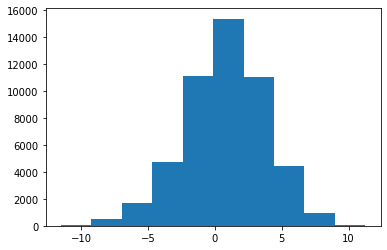

In [5]:
import matplotlib.pyplot as plt

plt.hist(submission1.rating)